# Загрузка и подготовка данных

Для начала соберем данные с сайта https://www.fanfiction.net/book/Harry-Potter/, а именно пройдемся по всем страницам и скачаем информацию о всех существующих фанфиках по Гарри Поттеру. Код, написанный мной, может это сделать, однако это займёт очень много времени. Поэтому я сделаю скрэппинг данных только за 2024-2020 год, а данные 2019-2004 возьму с сайта https://www.kaggle.com/datasets/nehatiwari03/harry-potter-fanfiction-data?resource=download. Данные на этом сайте также были получены скрэппингом того же сайта, но 4 года назад, когда на fanfiction ещё не было защиты от парсинга.

Установим базовый путь к данным. При необходимости подключаем Google Colab.

In [1]:
# Uncomment the lines if running on Google Colab
# from google.colab import drive
#
# drive.mount("/content/gdrive")

In [2]:
# DATA_DIR = "/content/gdrive/MyDrive/Colab Notebooks/"  # for colab
DATA_DIR = "../data/"  # for local development

Приведем датасеты в один вид и соединим их. Для этого переименуем столбцы, приведем содержимое столбцов в один формат данных и поменяем столбцы местами.

In [3]:
# Загружаем датасет с 2004 по 2019 год
from analysis.data import read_data_part1, read_data_part2

df_part1 = read_data_part1(data_dir=DATA_DIR)
df_part2 = read_data_part2(data_dir=DATA_DIR)

In [4]:
# Удаляем ненужные столбцы, переименовываем столбцы, приводим к корректным типам данных, заполняем пропуски
from analysis.data import prepare_data_part1, prepare_data_part2

df_part1_prepared = prepare_data_part1(df_part1)
df_part2_prepared = prepare_data_part2(df_part2)

В датасет 2020-2024 нужно добавить столбец пейрингов путем выделения текста в квадратных скобках из столбца персонажей, для этого воспользуемся регулярными функциями.

In [5]:
from analysis.features import add_pairings

df_part2_prepared = add_pairings(df_part2_prepared)

Важно заметить, что мы скачивали новые данные сверху вниз как они расположены на сайте, а на сайте они расположены по дате обновления. То есть в датасетах фанфики, которые были обновлены после 2019 года, попали в два датасета. Избавимся от дубликатов на оснвое параметров: автор, название, язык и дата публикации и оставим строчки именно из нового датасета, который мы скрэппили.

In [6]:
from analysis.data import remove_duplicates, create_union_data

df = create_union_data(df_part1_prepared, df_part2_prepared)
df = remove_duplicates(df)

Мы подготовили датасет. Теперь посмотрим на его базовые параметры.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 694495 entries, 0 to 51124
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Chapters    694495 non-null  int64         
 1   Favs        694495 non-null  float64       
 2   Follows     694495 non-null  float64       
 3   Published   694495 non-null  datetime64[ns]
 4   Reviews     694495 non-null  float64       
 5   Words       694495 non-null  int64         
 6   author      694495 non-null  object        
 7   characters  632237 non-null  object        
 8   genre       629379 non-null  object        
 9   language    694495 non-null  object        
 10  rating      694495 non-null  object        
 11  story_link  694495 non-null  object        
 12  synopsis    694484 non-null  object        
 13  title       694474 non-null  object        
 14  pairing     394364 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(9)
mem

In [8]:
df.head()

,Chapters,Favs,Follows,Published,Reviews,Words,author,characters,genre,language,rating,story_link,synopsis,title,pairing
0,1,2.0,0.0,2019-12-31,1.0,6840,reviews,"Sirius B., Remus L., James P., Regulus B.",Angst/Hurt/Comfort,English,T,https://www.fanfiction.net/s/13466909/1/If-You...,Regulus and James aren't happy. They know they...,If You Change Your Mind,NaN
1,1,1.0,0.0,2019-12-31,0.0,10962,JoyI9199,"Harry P., Draco M., Narcissa M., Charlie W.",Angst/Drama,English,M,https://www.fanfiction.net/s/13466894/1/Bloody...,When a plot from the Founder's age is revealed...,Bloody Ballgowns,NaN
2,1,3.0,2.0,2019-12-31,0.0,8592,MoonytheMarauder1,"[James P., Regulus B.]",Angst,English,M,https://www.fanfiction.net/s/13466885/1/Nothin...,"Regulus Black is supposed to be dead, but he's...",Nothing Left To Do,"James P., Regulus B."
3,2,0.0,0.0,2019-12-31,0.0,7260,LaviniaKatt,Cedric D.,Romance/Fantasy,English,M,https://www.fanfiction.net/s/13466880/1/Patien...,This is a spin off of Harry Potter taking plac...,Patience is a Virtue,NaN
4,1,4.0,3.0,2019-12-31,0.0,1529,Rowena-Moon-Moon,NaN,NaN,English,T,https://www.fanfiction.net/s/13466807/1/An-Und...,Harry makes a new discovery and perhaps a few ...,An Understanding,NaN


# Гипотеза 1: Популярность фанфиков (измеряемая количеством избранных, подписчиков и обзоров) со временем возросла

Для начала давайте поймём популярны ли всё еще фанфики. Поэтому посмотрим на популярность фанфиков со временем, опираясь на показатели лайков, подписчиков и отзывов. Для этого группируем фанфики по годам, чтобы получить среднегодовые показатели

In [9]:
import pandas as pd

df["Published"] = pd.to_datetime(df["Published"])
df["year"] = df["Published"].dt.year
df["month"] = df["Published"].dt.month

yearly_data = df.groupby("year").agg({"Favs": "mean", "Follows": "mean", "Reviews": "mean"}).reset_index()

 Видим, что пик популярности фанфиков в мире был в 2008-2010 и в 2015-2016 годах, а на момент 2019 года идет на спад. Однако также учтем тот факт, что чем новее фанфик, тем меньше у него лайков и отзывов, потому что он еще не успел их набрать, поэтому очевидно, что новые фанфики(на момент 2019 года) будут иметь низкие покатели.

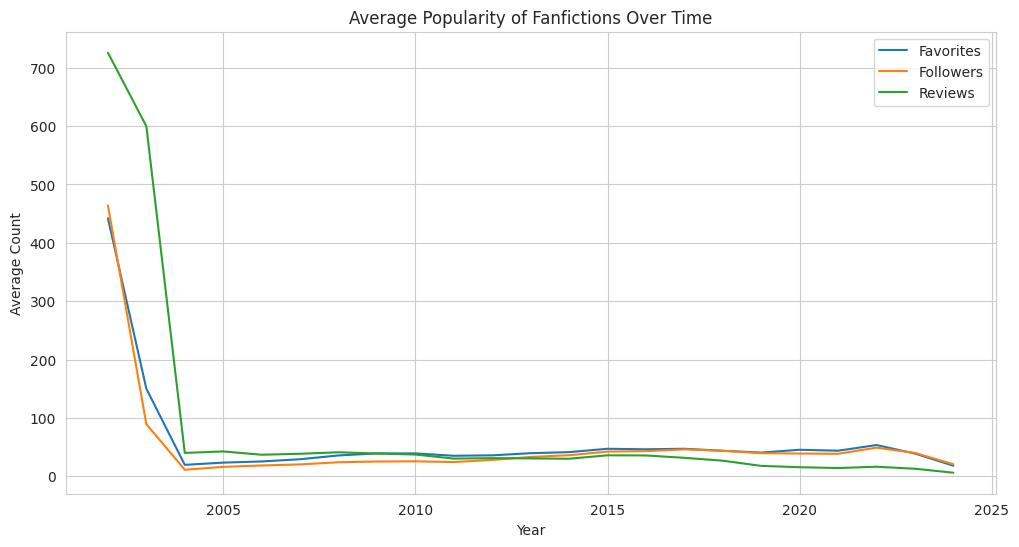

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(data=yearly_data, x="year", y="Favs", label="Favorites")
sns.lineplot(data=yearly_data, x="year", y="Follows", label="Followers")
sns.lineplot(data=yearly_data, x="year", y="Reviews", label="Reviews")
plt.title("Average Popularity of Fanfictions Over Time")
plt.xlabel("Year")
plt.ylabel("Average Count")
plt.legend()
plt.show()

# Гипотеза 2: Более длинные фанфики более популярны

Теперь давайте определим какого размера фанфик лучше всего писать. Нужно понять писать длинный фанфик или короткий? Посмотрим на зависимость количества слов и количества лайков и зависимость количества слов и количества подписчиков. Для этого проведем регрессионый анализ, построим график рассеяния с линией регрессии и тепловую карту матрицы корреляций

In [11]:
import statsmodels.api as sm

# Линейная регрессия между количеством слов и лайками
X = df["Words"]
y_fav = df["Favs"]
X = sm.add_constant(X)
model_fav = sm.OLS(y_fav, X).fit()
predictions_fav = model_fav.predict(X)

model_fav.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Favs   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                 6.368e+04
Date:                Sun, 09 Jun 2024   Prob (F-statistic):               0.00
Time:                        18:10:49   Log-Likelihood:            -4.3816e+06
No. Observations:              694495   AIC:                         8.763e+06
Df Residuals:                  694493   BIC:                         8.763e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.9166      0.168    142.740      0.000      23.588      24.245
Words          0.0012   4.69e-06    252.342      0.000       0.001       0.001
==============================================================================
Omnibus:                  1974009.887   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     316176031446.188
Skew:                          37.501   Prob(JB):                         0.00
Kurtosis:                    3307.637   Cond. No.                     3.75e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.75e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [12]:
# Линейная регрессия между количеством слов и подписчиками
y_fol = df["Follows"]
model_fol = sm.OLS(y_fol, X).fit()
predictions_fol = model_fol.predict(X)

model_fol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Follows   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                 6.999e+04
Date:                Sun, 09 Jun 2024   Prob (F-statistic):               0.00
Time:                        18:10:49   Log-Likelihood:            -4.3731e+06
No. Observations:              694495   AIC:                         8.746e+06
Df Residuals:                  694493   BIC:                         8.746e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.8442      0.166     95.724      0.000      15.520      16.169
Words          0.0012   4.64e-06    264.548      0.000       0.001       0.001
==============================================================================
Omnibus:                  2113896.357   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     593506028329.768
Skew:                          45.237   Prob(JB):                         0.00
Kurtosis:                    4530.901   Cond. No.                     3.75e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.75e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

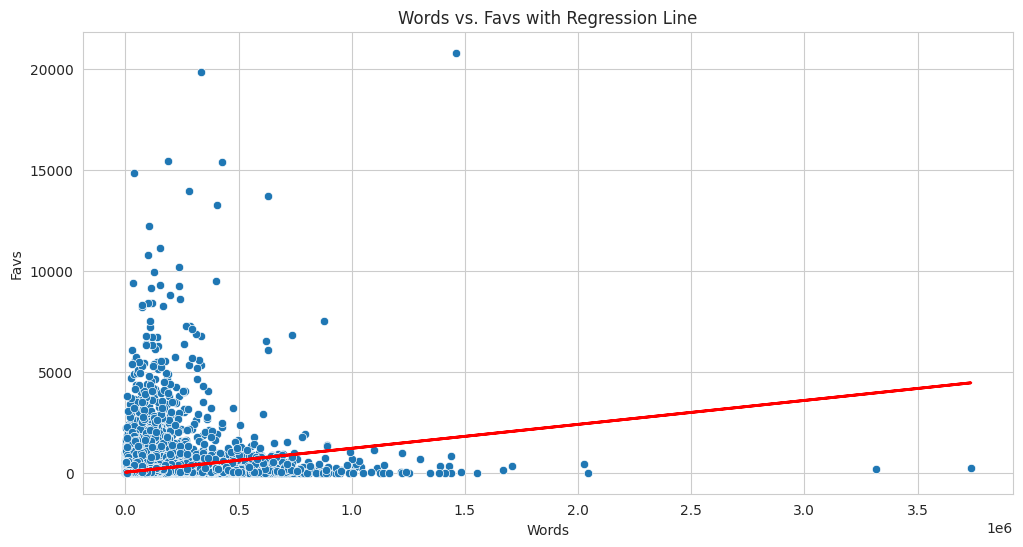

In [13]:
from analysis.visualization import plot_linreg_plot

plot_linreg_plot(x_data=df["Words"], y_data=df["Favs"], predictions=predictions_fav, x_label="Words", y_label="Favs")

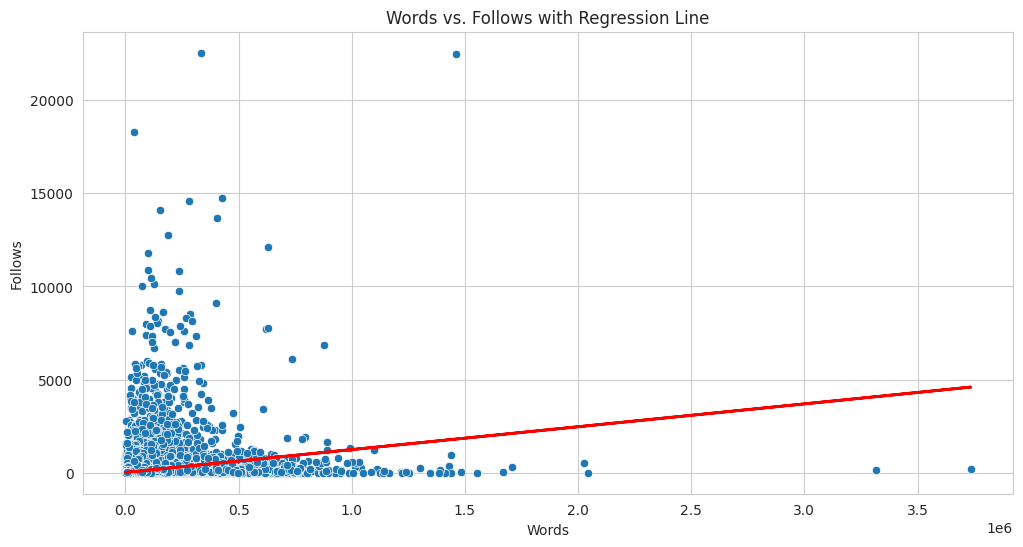

In [14]:
plot_linreg_plot(
    x_data=df["Words"], y_data=df["Follows"], predictions=predictions_fol, x_label="Words", y_label="Follows"
)

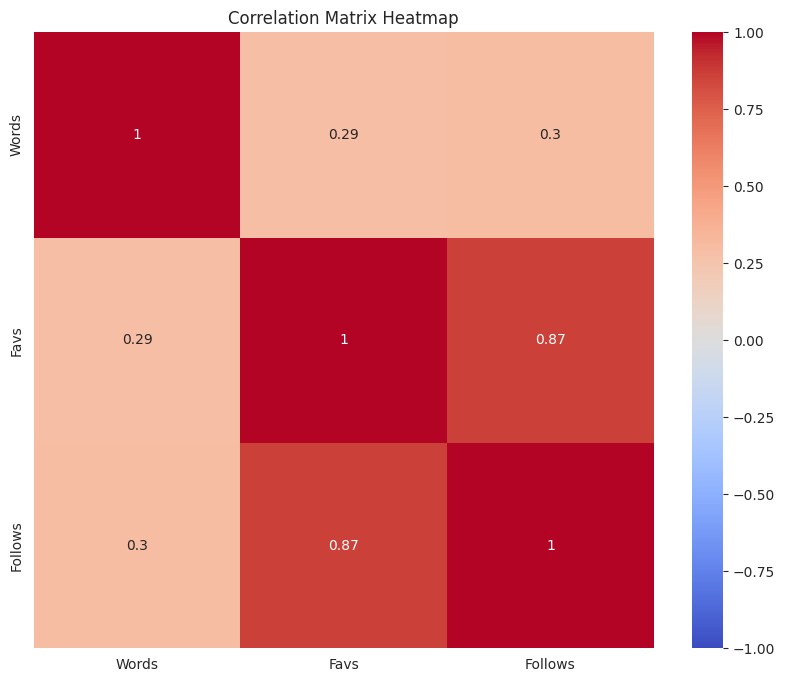

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

required_columns = ["Words", "Favs", "Follows"]
data = df[required_columns].dropna()

corr_matrix = data.corr()

# Тепловая карта матрицы корреляций
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix Heatmap")
plt.show()

Регрессионный анализ: \\
Лайки: \\
R-квадрат = 0,137. Указывает на то, что примерно 13,7% разницы в количестве лайков можно объяснить количеством слов в фанфике. \\
P = 0,000. Это предполагает наличие положительной связи между количеством слов и количеством лайков. В частности, за каждое дополнительное слово в фанфике количество лайков увеличивается примерно на 0,0034.
Подписчики: \\
R-квадрат = 0,144 указывает на то, что примерно 14,4% разницы в количестве подписчиков можно объяснить количеством слов в фанфике. \\
P = 0,000. Это предполагает наличие положительной связи между количеством слов и количеством подписчиков. В частности, за каждое дополнительное слово в фанфике количество подписчиков увеличивается примерно на 0,0029. \\

Корреляции Пирсона \\
Корреляция между словами и избранным: 0,3697 : эта положительная корреляция указывает на умеренную связь между количеством слов и количеством избранных. По мере увеличения продолжительности фанфика у него появляется больше фаворитов. \\
Корреляция между словами и подписчиками: 0,3798 : эта положительная корреляция также указывает на умеренную связь между количеством слов и количеством подписчиков. Более длинные фанфики привлекают больше последователей.
Общие выводы \\
Положительная связь : как регрессионный анализ, так и коэффициенты корреляции Пирсона указывают на положительную связь между длиной фанфика (измеряется по количеству слов) и его популярностью (измеряется по количеству избранных и подписчиков). У более длинных фанфиков, как правило, больше фаворитов и последователей. \\
Умеренное влияние : хотя отношения статистически значимы, значения R-квадрата предполагают, что помимо длины существуют и другие факторы, влияющие на количество избранных и подписчиков. Длина фанфика в некоторой степени объясняет разницу в его популярности. \\
Статистическая значимость : коэффициенты количества слов очень значимы в обеих моделях, что подтверждает вывод о том, что длина является важным предиктором показателей популярности, таких как избранное и подписчики.

# Гипотеза 3: Определенные персонажи и пары более популярны, чем другие.

Теперь нужно выяснить про какой пейринг писать фанфик, чтобы он стал наиболее популярным. Для этого построим граф с топ 25 популярными пейрингами, а затем узнаем, какие пейринги собрали в сумме больше всего лайков

Граф с топ 25 популярных пейрингов

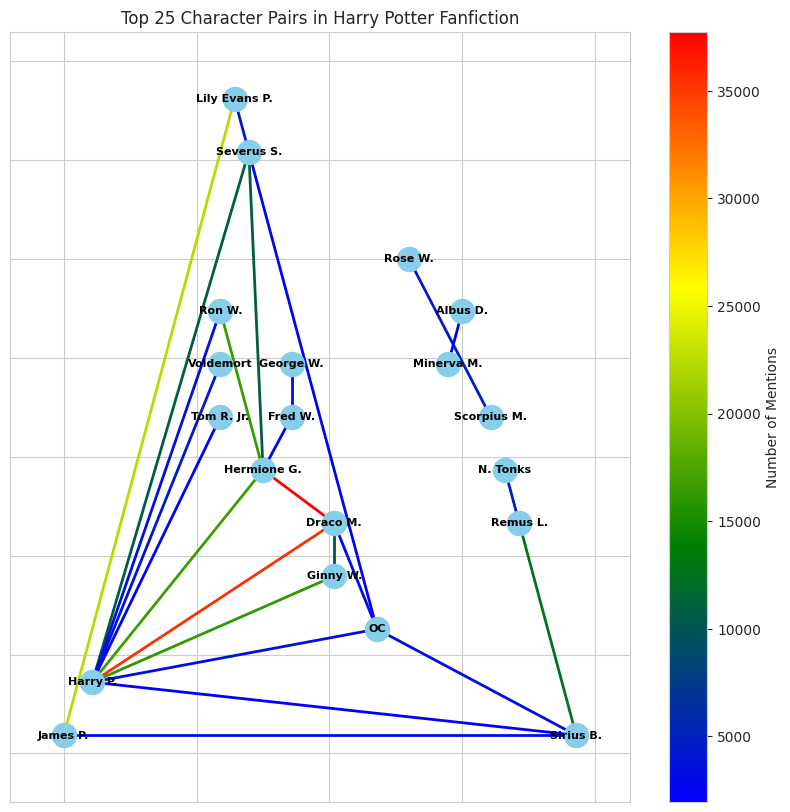

In [16]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from itertools import combinations
from matplotlib.colors import LinearSegmentedColormap

pairings_column = "pairing"

pairings = df[pairings_column].dropna().tolist()

# Смотрим все возможные комбинации пар и для каждой пары проверяем вхождение в пейринги фанфика и суммируем лайки по каждому подходящему фанфику
pair_counter = Counter()
for pairing in pairings:
    characters = [char.strip() for char in pairing.split(",")]
    if len(characters) > 1:
        for combo in combinations(characters, 2):
            pair_counter[tuple(sorted(combo))] += 1

# Топ 25 пар
top_15_pairs = pair_counter.most_common(25)

G = nx.Graph()
for pair, count in top_15_pairs:
    G.add_edge(pair[0], pair[1], weight=count)

# Определяем цвета ребер на основе веса
edge_weights = [G[u][v]["weight"] for u, v in G.edges()]
max_weight = max(edge_weights)
min_weight = min(edge_weights)

# Нормализуем веса между 0 и 1
normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in edge_weights]

# Генерируем цветовую карту: от синего к зеленому, к желтому и к красному
cmap = LinearSegmentedColormap.from_list("custom_cmap", ["blue", "green", "yellow", "red"])

# Генерация цветов: чем больше раз упоминается пара, тем краснее край; меньше раз, тем синее
edge_colors = [cmap(color) for color in normalized_weights]

# Исходный граф с планарной компоновкой
pos = nx.planar_layout(G)


# Function to move nodes manually
def move_node(pos, node, x, y):
    pos[node] = (x, y)


move_node(pos, "Rose W.", 0.3, 0.2)

# Draw the graph using the modified positions
plt.figure(figsize=(10, 10))
edges = nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=2)
nodes = nx.draw_networkx_nodes(G, pos, node_size=300, node_color="skyblue")
labels = nx.draw_networkx_labels(G, pos, font_size=8, font_weight="bold")

# Add color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_weight, vmax=max_weight))
sm._A = []

plt.colorbar(sm, label="Number of Mentions", ax=plt.gca())

plt.title("Top 25 Character Pairs in Harry Potter Fanfiction")
plt.show()

Видим, что самые популярные пейринги это Драрри и Драмиона, но также популяны и ДжеймсЛили, ГарииГермиона, РонГермиона. Теперь узнаем какие пейринги собирают больше всего лайков

In [17]:
import pandas as pd
from collections import Counter
from itertools import combinations

# Assuming the correct column name for 'pairings' and 'favorites'
pairings_column = "pairing"  # Replace with the correct column name if different
favorites_column = "Favs"  # Replace with the correct column name if different

data = df

# Ensure 'favorites' column is numeric
data[favorites_column] = pd.to_numeric(data[favorites_column], errors="coerce").fillna(0).astype(int)

# Initialize a counter for pairings with their total likes
pair_likes_counter = Counter()

# Process the 'pairings' column to accumulate likes
for index, row in data.iterrows():
    if pd.notna(row[pairings_column]):
        characters = [char.strip() for char in row[pairings_column].split(",")]
        if len(characters) > 1:
            likes = row[favorites_column]
            for combo in combinations(characters, 2):
                pair_likes_counter[tuple(sorted(combo))] += likes

# Get the top 5 pairings by total likes
top_5_pairs_by_likes = pair_likes_counter.most_common(5)

# Display the top 5 pairings
print("Top 5 pairings by total likes:")
for pair, total_likes in top_5_pairs_by_likes:
    print(f"Pair: {pair}, Total Likes: {total_likes}")

Top 5 pairings by total likes:
Pair: ('Draco M.', 'Harry P.'), Total Likes: 1951187
Pair: ('Draco M.', 'Hermione G.'), Total Likes: 1823896
Pair: ('Harry P.', 'Hermione G.'), Total Likes: 1074657
Pair: ('Harry P.', 'Severus S.'), Total Likes: 971580
Pair: ('Hermione G.', 'Severus S.'), Total Likes: 668406


Видим, что драрри и драмиона и по этому покателю в топе, однако здесь появляются новые пейринги, которые не так популярны в графе, а именно снари, и снейджер

Hypothesis 4: The rating of fanfictions affect their popularity.
Какой рейтинг выбирать? Посмотрим как со временем изменялась популярность рейтингов и какой рейтинг в сумме набрал больше всего лайков

In [18]:
import pandas as pd

# Ensure relevant columns are present and drop rows with missing values
required_columns = ["Published", "Favs", "Follows", "Reviews", "rating"]
dataf = df[required_columns].dropna()

# Parse the published date and extract the year
dataf["Published"] = pd.to_datetime(dataf["Published"])
dataf["year"] = dataf["Published"].dt.year

# Group by rating and year, and calculate the average annual indicators
grouped = dataf.groupby(["rating", "year"]).agg({"Favs": "mean", "Follows": "mean", "Reviews": "mean"}).reset_index()

/tmp/ipykernel_23739/4269575045.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_data["popularity_sum"] = rating_data["Favs"] + rating_data["Follows"] + rating_data["Reviews"]
/tmp/ipykernel_23739/4269575045.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_data["popularity_sum"] = rating_data["Favs"] + rating_data["Follows"] + rating_data["Reviews"]
/tmp/ipykernel_23739/4269575045.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

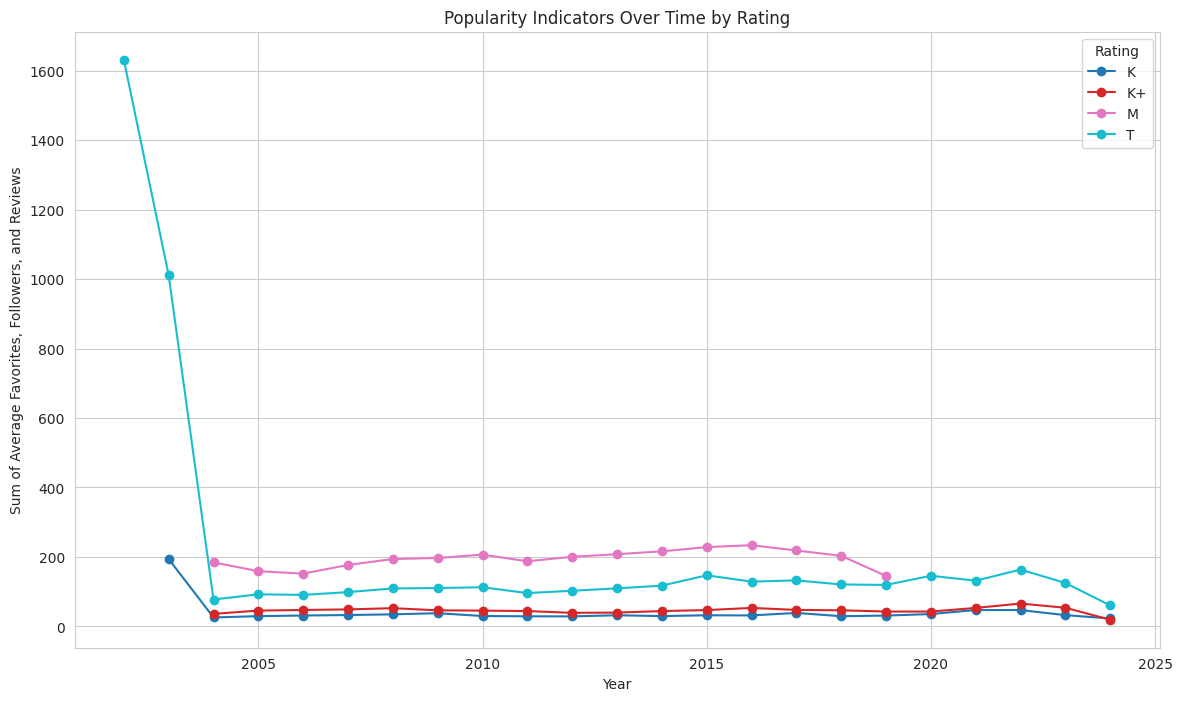

In [20]:
import matplotlib.pyplot as plt

# Plot the trends over time for each rating
plt.figure(figsize=(14, 8))

# List of unique ratings
ratings = grouped["rating"].unique()

# Colors for each rating plot
colors = plt.get_cmap("tab10", len(ratings))

# Plot for each rating
for idx, rating in enumerate(ratings):
    rating_data = grouped[grouped["rating"] == rating]

    # Summarize the data (sum of favorites, followers, and reviews)
    rating_data["popularity_sum"] = rating_data["Favs"] + rating_data["Follows"] + rating_data["Reviews"]

    # Plot the data
    plt.plot(rating_data["year"], rating_data["popularity_sum"], marker="o", label=rating, color=colors(idx))

# Customize the plot
plt.title("Popularity Indicators Over Time by Rating")
plt.xlabel("Year")
plt.ylabel("Sum of Average Favorites, Followers, and Reviews")
plt.legend(title="Rating")
plt.grid(True)

# Display the plot
plt.show()

Видим, что всегда популярнее рейтинг M

In [ ]:
import pandas as pd

# Assuming the correct column name for 'rating' and 'favorites'
rating_column = "rating"  # Replace with the correct column name if different
favorites_column = "Favs"  # Replace with the correct column name if different

data = df

# Ensure 'favorites' column is numeric
data[favorites_column] = pd.to_numeric(data[favorites_column], errors="coerce").fillna(0).astype(int)

# Sum the likes for each rating
rating_likes = dataf.groupby(rating_column)[favorites_column].sum()

# Sort the ratings by total likes in descending order
sorted_rating_likes = rating_likes.sort_values(ascending=False)

# Display the ratings by total likes
print("Ratings by total likes (in descending order):")
for rating, total_likes in sorted_rating_likes.items():
    print(f"Rating: {rating}, Total Likes: {total_likes}")

опять же больше всео M, значит пишем его

Hypothesis 5: The genre of fanfictions affect their popularity. Какой жанр выбирать? Посмотрим какая комбинация жанров приносит больше всего лайков

Функция get_all_combinations генерирует все возможные комбинации жанров.Код перебирает каждый фанфик, извлекает жанры и накапливает лайки для каждой комбинации жанров.
Код определяет комбинацию жанров, получившую наибольшее количество лайков, и печатает их.

In [ ]:
import pandas as pd
from itertools import chain, combinations

# Assuming the correct column name for 'genre' and 'favorites'
genre_column = "genre"  # Replace with the correct column name if different
favorites_column = "Favs"  # Replace with the correct column name if different

data = df

# Ensure 'favorites' column is numeric
data[favorites_column] = pd.to_numeric(data[favorites_column], errors="coerce").fillna(0).astype(int)


# Function to get all possible combinations of genres
def get_all_combinations(genres):
    return chain(*[combinations(genres, i) for i in range(1, len(genres) + 1)])


# Initialize a counter for genre combinations with their total likes
genre_combination_likes = {}

# Process the 'genre' column to accumulate likes for each combination
for index, row in data.iterrows():
    if pd.notna(row[genre_column]):
        genres = [genre.strip() for genre in row[genre_column].split("/")]
        likes = row[favorites_column]
        for combo in get_all_combinations(genres):
            combo_key = tuple(sorted(combo))
            if combo_key in genre_combination_likes:
                genre_combination_likes[combo_key] += likes
            else:
                genre_combination_likes[combo_key] = likes

# Find the combination with the most likes
max_likes = max(genre_combination_likes.values())
best_genre_combinations = [combo for combo, likes in genre_combination_likes.items() if likes == max_likes]

# Display the best genre combination(s) and the total likes
print("Best genre combination(s) by total likes:")
for combo in best_genre_combinations:
    if len(combo) == 1:
        print(f"Genres: {combo[0]}, Total Likes: {max_likes}")
    else:
        print(f"Genres: {combo}, Total Likes: {max_likes}")

Значит выбираем Romance жанр

Hypothesis 6: The synopsis length correlates with the number of reviews and followers.

In [ ]:
import pandas as pd

# Ensure relevant columns are present and drop rows with missing values
required_columns = ["synopsis", "Reviews", "Follows", "Favs"]
data = df
data["Reviews"] = pd.to_numeric(data["Reviews"], errors="coerce")
data["Follows"] = pd.to_numeric(data["Follows"], errors="coerce")
data = data[required_columns].dropna()

# Calculate the length of the synopsis
data["synopsis_length"] = data["synopsis"].apply(len)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the relationship between synopsis length and number of reviews
plt.figure(figsize=(12, 6))
sns.scatterplot(x="synopsis_length", y="Reviews", data=data)
plt.title("Synopsis Length vs. Number of Reviews")
plt.xlabel("Synopsis Length")
plt.ylabel("Number of Reviews")
plt.show()

# Plot the relationship between synopsis length and number of followers
plt.figure(figsize=(12, 6))
sns.scatterplot(x="synopsis_length", y="Follows", data=data)
plt.title("Synopsis Length vs. Number of Followers")
plt.xlabel("Synopsis Length")
plt.ylabel("Number of Followers")
plt.show()

In [ ]:
from scipy.stats import pearsonr
import statsmodels.api as sm

# Calculate Pearson correlation coefficient for synopsis length vs. reviews
corr_reviews, p_value_reviews = pearsonr(data["synopsis_length"], data["Reviews"])
print(f"Pearson correlation (reviews): {corr_reviews}, P-value: {p_value_reviews}")

# Calculate Pearson correlation coefficient for synopsis length vs. followers
corr_followers, p_value_followers = pearsonr(data["synopsis_length"], data["Follows"])
print(f"Pearson correlation (followers): {corr_followers}, P-value: {p_value_followers}")

# Linear regression for synopsis length vs. reviews
X_reviews = sm.add_constant(data["synopsis_length"])
y_reviews = data["Reviews"]
model_reviews = sm.OLS(y_reviews, X_reviews).fit()
print(model_reviews.summary())

# Linear regression for synopsis length vs. followers
X_followers = sm.add_constant(data["synopsis_length"])
y_followers = data["Follows"]
model_followers = sm.OLS(y_followers, X_followers).fit()
print(model_followers.summary())

Отзывы:
Коэффициент корреляции: 0,0917
P-значение: 0,0
Интерпретация: Существует слабая положительная корреляция между длиной синопсиса и количеством рецензий. Значение p указывает на то, что эта корреляция статистически значима.

Последователи:
Коэффициент корреляции: 0,1263
P-значение: 0,0
Интерпретация: Существует слабая положительная корреляция между длиной синопсиса и количеством подписчиков. Значение p указывает на то, что эта корреляция статистически значима.

Регрессионный анализ OLS
Отзывы
Краткое описание модели:
R-квадрат: 0,008
Прил. R-квадрат: 0,008
F-статистика: 551,1 (значение p: 0,0)
Интерпретация: Модель объясняет 0,8% дисперсии количества отзывов. Это указывает на очень слабую связь между длиной синопсиса и количеством рецензий.

Коэффициенты:
Перехват (const): -2,6985 (значение p: 0,000)
Длина синопсиса: 0,2034 (значение p: 0,000)
Интерпретация: Длина синопсиса оказывает небольшое положительное влияние на количество рецензий. Ожидается, что для каждого дополнительного символа в синопсисе количество обзоров увеличится примерно на 0,2034 при неизменных других факторах.

Последователи
Краткое описание модели:
R-квадрат: 0,016
Прил. R-квадрат: 0,016
F-статистика: 10520,4 (значение p: 0,0)
Интерпретация: Модель объясняет 1,6% дисперсии числа подписчиков. Это указывает на слабую связь между длиной синопсиса и количеством подписчиков.

Коэффициенты:
Перехват (const): -22,9205 (значение p: 0,000)
Длина синопсиса: 0,3547 (значение p: 0,000)
Интерпретация: Длина синопсиса оказывает небольшое положительное влияние на количество подписчиков. Ожидается, что для каждого дополнительного персонажа в синопсисе число подписчиков увеличится примерно на 0,3547 при прочих равных факторах.

Общие выводы
Статистическая значимость: коэффициенты корреляции и регрессии статистически значимы (значение p <0,05), что указывает на то, что взаимосвязь между длиной синопсиса и количеством обзоров и подписчиков не является случайной.

Сила связи: Хотя связи статистически значимы, значения R-квадрата очень низкие (0,8% для отзывов и 1,6% для подписчиков). Это говорит о том, что длина синопсиса объясняет лишь небольшую часть различий в количестве обзоров и подписчиков. Другие факторы, вероятно, играют более важную роль в определении популярности.

Hypothesis 7: Наличие определенных ключевых слов в названии коррелирует с более высокой популярностью (лайки).

Нам нужно придумать название, а для этого нужно понять, важно ли, какие слова использовать. Построим облако слов, выъявив какие слова самые популярные, а затем с помощью регулярных функций посмотрим на корелляцию самых популярных слов и количество лайков

In [ ]:
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Generate a word cloud of synopses
text = " ".join(df["title"].dropna())
wordcloud = WordCloud(width=800, height=400).generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Define keywords to search for using regular expressions
keywords = ["secret", "hogwarts", "Harry", "love", "life", "time", "heart"]


# Use regular expressions to check for keywords in the synopsis
def contains_keywords(text, keywords):
    pattern = "|".join(keywords)  # Create a regex pattern
    return bool(re.search(pattern, str(text), re.IGNORECASE))


# Apply the function to the 'synopsis' column
data["keyword_present"] = df["title"].apply(lambda x: contains_keywords(x, keywords))

# Correlation test between keyword presence and favorites
corr = data[["keyword_present", "Favs"]].corr()
print("Correlation between keyword presence and favorites:", corr)

Теперь построим предсказательную модель дерева решений, которая но основе жанра, языка и рейтинга фанфика будет предсказывать количество лайков. Построим гистограмму, показывающую важность каждого параметра для прогнозирования количества лайков. Функции с более высокими значениями важности оказывают большее влияние на прогнозы модели.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

data = df

# Prepare data
features = ["genre", "language", "rating"]
X = pd.get_dummies(data[features])
y = data["Favs"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

# Feature importance
importance = model.feature_importances_

# Group genre, rating, language, and pairing importance
importances = pd.Series(importance, index=X.columns)
genre_importance = importances[X.columns.str.startswith("genre_")].sum()
rating_importance = importances[X.columns.str.startswith("rating_")].sum()
language_importance = importances[X.columns.str.startswith("language_")].sum()

# Create a new Series for plotting
combined_importance = importances[
    ~X.columns.str.startswith("genre_") & ~X.columns.str.startswith("rating_") & ~X.columns.str.startswith("language_")
]
combined_importance["genre"] = genre_importance
combined_importance["rating"] = rating_importance
combined_importance["language"] = language_importance

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=combined_importance.values, y=combined_importance.index)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

Видим, что больше всего влияет рейтинг. Далее проверим точность модели, оценим это по MSE. Сравним MSE нашей модели и MSE базовой модели , прогозирующей среднее значение лайков.

In [ ]:
from sklearn.metrics import mean_squared_error

baseline_pred = y_train.mean()
baseline_mse = mean_squared_error(y_test, [baseline_pred] * len(y_test))

print(f"Model MSE: {mse}")
print(f"Baseline MSE (Mean Prediction): {baseline_mse}")

MSE нашей модели меньше, чем MSE базовой модели, следовательно, модель работает лучше, чем просто прогнозирование среднего значения целевой переменной, а значит можно считать, что наша модель применима. Тогда расчитаем примерное количество лайков на основе показателей, которые в ходе исследования мы получили как наиболее эффективные: \\
язык - английский, \\
жанр - романтика, \\
рейтинг - M.
Получаем в среднме 112.9 лайков, что в целом неплохо, тк среднее значение лайков по фанфикам равно 53.3

In [ ]:
# Define a function to prepare the input data and make a prediction
def predict_reviews(language, genre, rating, model, feature_columns):
    # Create a DataFrame for the new input
    input_data = pd.DataFrame({"genre": [genre], "rating": [rating], "language": [language]})

    # Convert categorical features to dummy variables
    input_data = pd.get_dummies(input_data)

    # Reindex the input data to match the training data columns
    input_data = input_data.reindex(columns=feature_columns, fill_value=0)

    # Make a prediction using the trained model
    predicted_reviews = model.predict(input_data)

    return predicted_reviews[0]


# Example usage
language = "English"  # Example language
genre = "Romance"  # Example genre
rating = "M"  # Example rating

# Ensure the columns match the training data
feature_columns = X.columns  # Use the columns from the training data

# Predict the number of reviews
predicted_reviews = predict_reviews(language, genre, rating, model, feature_columns)
print(f"Predicted number of reviews: {predicted_reviews}")

In [ ]:
df["Favs"].mean()